## 실습 3. Convolutional VAE
### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Flatten, Dense, Conv2D, InputLayer, Reshape, Conv2DTranspose
from IPython import display

## Load the MNIST dataset

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

train_images /= 255.
test_images /= 255.

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

## Use *tf.data* to create batches and shuffle the dataset

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [5]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

    self.inference_net = tf.keras.Sequential([
      InputLayer(input_shape=(28, 28, 1)),    
      Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'), #(13,13,32)
      Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'), #(6,6,64)
      Flatten(),  # 6*6*64 = (2304,)
      # No activation
      Dense(latent_dim + latent_dim), #(4,)
    ])

    self.generative_net = tf.keras.Sequential([
      InputLayer(input_shape=(latent_dim,)), #(2,)
      Dense(units=7*7*32, activation=tf.nn.relu), # 7*7*32 = (1568,)
      Reshape(target_shape=(7, 7, 32)), 
      Conv2DTranspose(filters=64,kernel_size=3,strides=(2, 2),padding="SAME",activation='relu'), #(14,14,64)
      Conv2DTranspose(filters=32,kernel_size=3,strides=(2, 2),padding="SAME",activation='relu'), #(28,28,32)
      # No activation
      Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1),padding="SAME"), #(28,28,1)
    ])

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=True):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits
	

In [6]:
from tensorflow.keras import backend as K

optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z, apply_sigmoid=False)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  kl_loss = 5e-4 * K.mean(1 + logvar - K.square(mean) - K.exp(logvar), axis=-1)
  return K.mean(cross_ent - kl_loss)

def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [7]:
epochs = 100
latent_dim = 2
num_examples_to_generate = 16

model = CVAE(latent_dim)

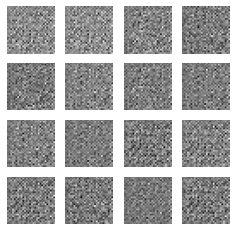

In [8]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model.decode(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 100, Test set ELBO: -0.19084703922271729, time elapse for current epoch 8.940069198608398


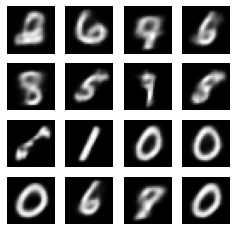

In [9]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

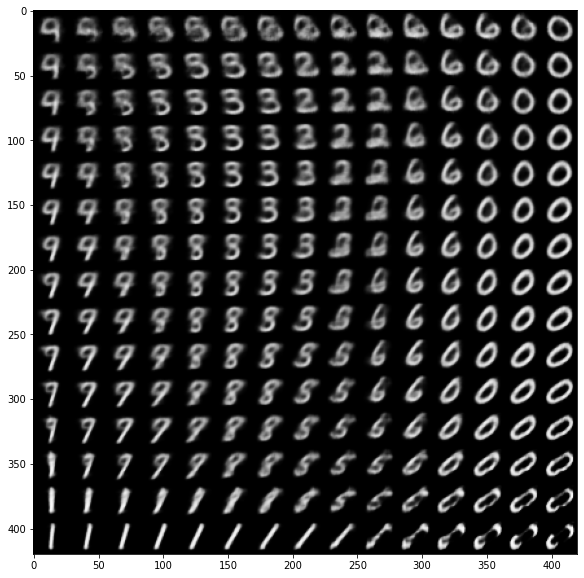

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 1
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
z_sample = np.zeros((n,n,2))
for i, xi in enumerate(grid_x):
  for j, yi in enumerate(grid_y):
    z_sample[i][j]=[xi,yi]
  predictions = model.decode(z_sample[i])
  predictions.numpy()

  for j in range(n):
    digit = predictions[j].numpy().reshape(digit_size, digit_size)

    figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.show()